<a href="https://colab.research.google.com/github/caesarcc/python-tcc-url-fakenews-check/blob/main/jupyter/bert_best_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers
!pip install -q lime

     |████████████████████████████████| 4.0 MB 8.7 MB/s 
     |████████████████████████████████| 6.6 MB 37.5 MB/s 
     |████████████████████████████████| 596 kB 63.1 MB/s 
     |████████████████████████████████| 880 kB 43.7 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
     |████████████████████████████████| 275 kB 9.9 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer
from transformers import get_linear_schedule_with_warmup
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import random
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from lime.lime_text import LimeTextExplainer


In [5]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [6]:
model = BertForSequenceClassification.from_pretrained("neuralmind/bert-base-portuguese-cased", num_labels=2, output_attentions=False, output_hidden_states=False)
tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased", do_lower_case=False)


Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

In [7]:
df = pd.read_csv('drive/MyDrive/PUC/TCC/dados/fakebr_corpus_processado.csv')
textlens = []
for elem in df['texto_processado']:
    textlens.append(len(elem))

In [8]:
bins = np.arange(1,512,1)

In [9]:
values, counts = np.unique(textlens, return_counts=True)

Text(0, 0.5, 'Count')

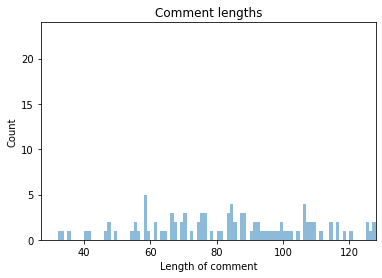

In [ ]:
plt.figure()
plt.xlim([min(textlens)-5, 128])
plt.ylim([0,max(counts) + 5])
plt.hist(textlens, bins=bins, alpha=0.5)
plt.title('Comment lengths')
plt.xlabel('Length of comment')
plt.ylabel('Count')
plt.show()

In [10]:
newdf = df[['classe','texto_processado']].copy()

newdf['TOKENS'] = newdf['texto_processado'].apply(lambda x: np.array(tokenizer.encode(x, padding='max_length', truncation=True, max_length=400)))
newdf['LABELS'] = newdf['classe']
newdf = newdf[['TOKENS','LABELS']]

In [11]:
np.random.seed(42)
train, validate, test = np.split(newdf.sample(frac=1), [int(.7*len(df)), int(.8*len(df))])

In [15]:
train_values = torch.tensor(train['TOKENS'].values.tolist()).to(torch.int64)
train_labels = torch.tensor(train.LABELS.values.tolist()).to(torch.int64)
val_values = torch.tensor(validate['TOKENS'].values.tolist()).to(torch.int64)
val_labels = torch.tensor(validate.LABELS.values.tolist()).to(torch.int64)
test_values = torch.tensor(test['TOKENS'].values.tolist()).to(torch.int64)
test_labels = torch.tensor(test.LABELS.values.tolist()).to(torch.int64)

In [17]:
epochs = 5
batch_size = 16

train_data = TensorDataset(train_values, train_labels)
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)

val_data = TensorDataset(val_values, val_labels)
val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=batch_size)

device = 'cuda'
model.to(device)

total_steps = len(train_dataloader) * epochs
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

seed_val = 9773
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [27]:
training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()

    # Reset the total loss for this epoch
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)
        
        model.zero_grad()        
        
        loss = model(b_input_ids, 
                             token_type_ids=None,
                             labels=b_labels).loss
        #loss = torch.nn.CrossEntropyLoss(outputs, b_labels)
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    print("")
    print("Running Validation...")
    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)
        
        with torch.no_grad():        
            
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None,
                                   labels=b_labels)
            
        total_eval_loss += loss
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )


======== Epoch 1 / 5 ========
Training...


RuntimeError: ignored

In [ ]:
print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
#%%
test_data = TensorDataset(test_values, test_labels)
test_dataloader = DataLoader(test_data, sampler=SequentialSampler(test_data), batch_size=batch_size)
#%%
# Put model in evaluation mode
model.eval()

Tracking variables 

In [ ]:
predictions , true_labels = [], []

Predict 

In [ ]:
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_labels = batch
  
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None)

In [ ]:
  logits = outputs[0]

In [ ]:
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [ ]:
print('    DONE.')
#%%
flat_predictions = np.concatenate(predictions, axis=0)

In [ ]:
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [ ]:
flat_true_labels = np.concatenate(true_labels, axis=0)
#%%

In [ ]:
print(classification_report(flat_true_labels, flat_predictions,target_names=['ham','spam']))

%

In [ ]:
fpr, tpr, _ = roc_curve(flat_true_labels, flat_predictions)
roc_auc = auc(fpr, tpr)
#%%
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
#%%
print(accuracy_score(flat_true_labels, flat_predictions))

%

In [ ]:
conf = confusion_matrix(flat_true_labels, flat_predictions)
print(conf)
#%%
pd.set_option('precision', 2)

Create a DataFrame from our training statistics.

In [ ]:
df_stats = pd.DataFrame(data=training_stats)

Use the 'epoch' as the row index.

In [ ]:
df_stats = df_stats.set_index('epoch')
#%%
plt.figure()
# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

Label the plot.

In [ ]:
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

In [ ]:
plt.show()

%

In [ ]:
plt.figure()
plt.plot(df_stats['Valid. Accur.'], 'g-o', label="Validation")

Label the plot.

In [ ]:
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.xticks([1, 2, 3, 4])

In [ ]:
plt.show()

%

In [ ]:
model.eval()
from scipy.special import softmax
def predictor(text):
    temp = pd.DataFrame(text,columns = ['plaintext'])
    temp['tokens'] = temp['plaintext'].apply(lambda x: np.array(tokenizer.encode(x,add_special_tokens=True, max_length = 128,pad_to_max_length=True)))
    values = torch.tensor(temp['tokens'].values.tolist()).to(torch.int64)
    values = values.to(device)
    
    results = []
    for value in values:
        with torch.no_grad():
            outputs = model(value.unsqueeze(0),token_type_ids=None)
        logits = outputs[0]
        logits = logits.cpu().detach().numpy()
        logits = softmax(logits)
        results.append(logits[0])
    results_array = np.array(results)
    return results_array
#%%
class_names = ['Ham','Spam']
#%%
explainer = LimeTextExplainer(class_names=class_names)
#%%
idx = 453
exp = explainer.explain_instance(df['CONTENT'][idx], predictor)
print('Comment no: %d' % idx)
print('Comment body: %s' % df['CONTENT'][idx])
print('True class: %s' % class_names[df['CLASS'][idx]])
#%%
print(exp.as_list())
#%%
exp.save_to_file('./id%d.html' % idx)